# Retrieving and Preparing the Data

In [1]:
# Initiallistions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initiallise raw dataframe to raw_df
raw_df = pd.read_csv('DataSets/Heart failure clinical records Data Set/heart_failure_clinical_records_dataset.csv', sep = ',')

# We will create a copy for this raw dataframe and name it 'df'
# This dataframe will be the primary source of further investigations.
# The 'raw' dataframe is kept for future reference if need be, as some data may be lost in the cleaning process.
df = raw_df.copy()
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Data Cleaning

Initial observations of the dataset show no null/NA values.

In [2]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [3]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

However, the 'age' category is described as a floating point decimal data type, which contradicts the dataset's description of this attribute being an integer. In order so see why this is the case, we will now display all values that are not valid as integers:

In [4]:
df[df['age'] % 1 != 0]['age']

185    60.667
188    60.667
Name: age, dtype: float64

As shown, the values in which are decimal are two patients with ages of `'60.667'`. It has been decided to round these numbers down, to properly fit within the feature's description.

In [5]:
df['age'] = df['age'].apply(np.floor)
df[df['age'] % 1 != 0]['age']

Series([], Name: age, dtype: float64)

There are no more decimal numbers in `'age'`. We may now convert the data type back to `integer`.

In [6]:
df['age'] = df['age'].astype('int')
df['age'].dtypes

dtype('int32')

The next attribute we will look at is `'creatinine_phosphokinase'`. This variable describes the patient's level of creatinine phosphokinase (CPK) in the blood. This is measured in mcg/L (micrograms per Litre) at a range of `23` to `7861` mcg/L.

In [7]:
print(f"""The minimum in this feature is {df['creatinine_phosphokinase'].min()}, 
    the maximum is {df['creatinine_phosphokinase'].max()}, 
    and its data type is \"{df['creatinine_phosphokinase'].dtypes}\".""")

The minimum in this feature is 23, 
    the maximum is 7861, 
    and its data type is "int64".


In order to optimise the memory usage of this dataframe, we will assume that the amount of CPK in a patient's blood will not exceed that of the maximum number describable by the `int16` datatype, which is `32767`, and as such convert this feature to this less memory-rich datatype.

While this won't make a significant difference in this dataset of 299 patients, this practice is healthy in the event that a larger database is provided.

In [8]:
df['creatinine_phosphokinase'] = df['creatinine_phosphokinase'].astype('int16')
print(f"""The minimum in this feature is {df['creatinine_phosphokinase'].min()}, 
    the maximum is {df['creatinine_phosphokinase'].max()}, 
    and its data type is \"{df['creatinine_phosphokinase'].dtypes}\".""")

The minimum in this feature is 23, 
    the maximum is 7861, 
    and its data type is "int16".


We will similarly conduct the same method for the `'age'` feature, where the maximum number describable with `'int8'` being `127`.

In [9]:
df['age'] = df['age'].astype('int8')
print(f"""The minimum in this feature is {df['age'].min()},
    the maximum is {df['age'].max()}, 
    and its data type is \"{df['age'].dtypes}\".""")

The minimum in this feature is 40,
    the maximum is 95, 
    and its data type is "int8".


And continue this method of integer optimisation for the `'ejection_fraction'`, `'serum_sodium'`, and `'time'` features.

In [10]:
df['ejection_fraction'] = df['ejection_fraction'].astype('int8')
df['serum_sodium'] = df['serum_sodium'].astype('int16')
df['time'] = df['time'].astype('int16')
df[['ejection_fraction', 'serum_sodium', 'time']].dtypes

ejection_fraction     int8
serum_sodium         int16
time                 int16
dtype: object

Whist exploring the other features, it was noticed that the `'platelets'` feature in the dataset are described as "kiloplatelets/mL" (<a href="https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1">Table 1 of the data's source document</a>), however the dataset given is in platelets/mL. This can easily be changed by dividing each platelet count by `1000`.

In [11]:
df['platelets'] = df['platelets'].div(1000).round(2)
df['platelets'].head()

0    265.00
1    263.36
2    162.00
3    210.00
4    327.00
Name: platelets, dtype: float64

Another strage pattern that was observed is that there are `25` intances where seperate patients have the exact same platelet count of `263.36 kiloplatelets/mL`.

In [12]:
df['platelets'].value_counts()

263.36    25
255.00     4
237.00     4
271.00     4
228.00     4
          ..
155.00     1
257.00     1
309.00     1
461.00     1
336.00     1
Name: platelets, Length: 176, dtype: int64

This is highly obscure and most likely an error with the data set, either with input or otherwise. These patients also display no other correlations, and as such, their observations must be removed from the database in order to ensure the modelling proccess is not given misleading data.

As far as I can tell, this anomaly has been overlooked by the <a href="https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5">original document</a>.

In [13]:
df[df['platelets'] == 263.36].head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
1,55,0,7861,0,38,0,263.36,1.10,136,1,0,6,1
8,65,0,157,0,65,0,263.36,1.50,138,0,0,10,1
24,75,0,582,1,30,1,263.36,1.83,134,0,0,23,1
30,94,0,582,1,38,1,263.36,1.83,134,1,0,27,1
40,70,0,582,0,20,1,263.36,1.83,134,1,1,31,1


In [14]:
df = df[df['platelets'] != 263.36].reset_index(drop=True)
df[df['platelets'] == 263.36]['platelets'].count()

0

In [15]:
print(f"The dataset now contains {df.shape[0]} patients.")

The dataset now contains 274 patients.


Similarly, the CPK feature contains `34` instances where the patient's reading is `582 mcg/L`. 

In [16]:
df['creatinine_phosphokinase'].value_counts()

582     34
66       4
129      4
47       3
115      3
        ..
149      1
151      1
154      1
156      1
1021     1
Name: creatinine_phosphokinase, Length: 197, dtype: int64

This is highly unlikely due to the measurement type being a highly variable statistic. It is again assumed to be erroneous and will be removed from the dataset.

In [17]:
df[df['creatinine_phosphokinase'] == 582].head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265.0,1.9,130,1,0,4,1
15,45,0,582,0,14,0,166.0,0.8,127,1,0,14,1
17,48,1,582,1,55,0,87.0,1.9,121,0,0,15,1
31,69,0,582,1,35,0,228.0,3.5,134,1,0,30,1
40,50,0,582,1,38,0,310.0,1.9,135,1,1,35,1


In [18]:
df = df[df['creatinine_phosphokinase'] != 582].reset_index(drop=True)
df[df['creatinine_phosphokinase'] == 582]['creatinine_phosphokinase'].count()

0

In [19]:
print(f"The dataset now contains {df.shape[0]} patients.")

The dataset now contains 240 patients.


## Pre-Processing

This section will primarily focus on pre-processing the binary features of the dataset to improve the data exploration section. Before continuing, we will make a copy of the dataframe in its current state such that it can be used for the modelling process later. The features in question are `'anaemia'`, `'diabetes'`, `'high_blood_pressure'`, `'smoking'`, and `'DEATH_EVENT'`.These variables describe a boolean value, where `0` is `false` and `1` is `true`. Another binary variable in this dataset describes `'sex'` as either a `0` or a `1`, however which gender each number signifies is unfortunately not defined in either the <a href="https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records">UCI Repository</a> nor <a href="https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5">the data's source document</a>.

These variable values, other than those given in `'sex'`, will now be given a more descriptive name.

In [20]:
df_before_pp = df.copy()
df[['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']]

,anaemia,diabetes,high_blood_pressure,smoking,DEATH_EVENT
0,0,0,0,1,1
1,1,0,0,0,1
2,1,1,0,0,1
3,1,0,1,1,1
4,1,0,0,0,1
...,...,...,...,...,...
235,0,1,1,1,0
236,0,0,0,0,0
237,0,1,0,0,0
238,0,0,0,1,0


In [21]:
df[['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']] = df[['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']].astype("bool")

# Create categories
cat_anaemia   = ['anaemic', 'normal']
cat_diabetes  = ['diabetic', 'normal']
cat_hbp       = ['hypertensive', 'normal']
cat_smoking   = ['smoker', 'non-smoker']
cat_death     = ['dead', 'alive']

# Apply categories
df['anaemia'] = np.select([df['anaemia'] == True, df['anaemia'] == False], cat_anaemia)
df['diabetes'] = np.select([df['diabetes'] == True, df['diabetes'] == False], cat_diabetes)
df['high_blood_pressure'] = np.select([df['high_blood_pressure'] == True, df['high_blood_pressure'] == False], cat_hbp)
df['smoking'] = np.select([df['smoking'] == True, df['smoking'] == False], cat_smoking)
df['DEATH_EVENT'] = np.select([df['DEATH_EVENT'] == True, df['DEATH_EVENT'] == False], cat_death)

# Additionally apply DEATH_EVENT category to df_before_pp
df_before_pp['DEATH_EVENT'] = np.select([df_before_pp['DEATH_EVENT'] == 1, df_before_pp['DEATH_EVENT'] == 0], cat_death)

df[['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']]

,anaemia,diabetes,high_blood_pressure,smoking,DEATH_EVENT
0,normal,normal,normal,smoker,dead
1,anaemic,normal,normal,non-smoker,dead
2,anaemic,diabetic,normal,non-smoker,dead
3,anaemic,normal,hypertensive,smoker,dead
4,anaemic,normal,normal,non-smoker,dead
...,...,...,...,...,...
235,normal,diabetic,hypertensive,smoker,alive
236,normal,normal,normal,non-smoker,alive
237,normal,diabetic,normal,non-smoker,alive
238,normal,normal,normal,smoker,alive


In this section, for simplicity we will also divide the `'age'` feature into two classifications as seperated by the median age: `'middleage': 40-59` and `'elderly': 60+`.

In [22]:
print(f"The median age for this dataset is {df['age'].median().astype('int')}.")

The median age for this dataset is 60.


In [23]:
conditions = [df['age'] < df['age'].median(), df['age'] >= df['age'].median()]
category = ["middleage", "elderly"]

df['age'] = np.select(conditions, category)
df[['age']].head()

,age
0,elderly
1,middleage
2,elderly
3,elderly
4,elderly


Now that the dataset and dataframe is clean and preprocessed, we are ready for investigation.

# Data Exploration

In [24]:
# Adjust font size here
font = {'size'   : 22}
plt.rc('font', **font)

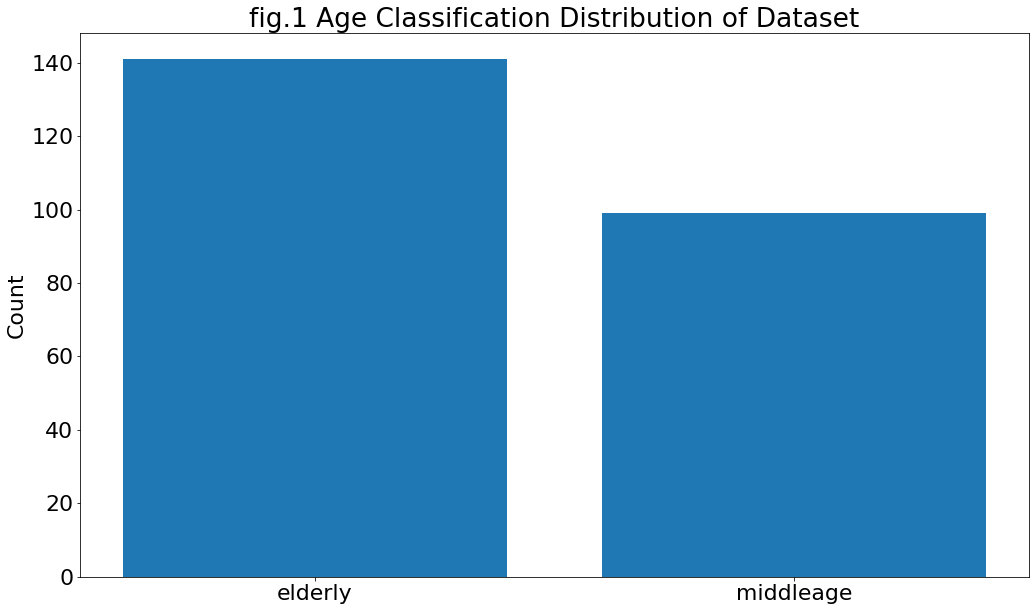

In [25]:
fig01, ax01 = plt.subplots()

ax01.bar(df['age'].unique(), df['age'].value_counts())

plt.title("fig.1 Age Classification Distribution of Dataset")
plt.ylabel("Count")
fig01.set_size_inches(17, 10)
plt.show()

In [26]:
df['age'].value_counts()

elderly      141
middleage     99
Name: age, dtype: int64

There are significantly more elderly patients in this dataset than middleaged patients.

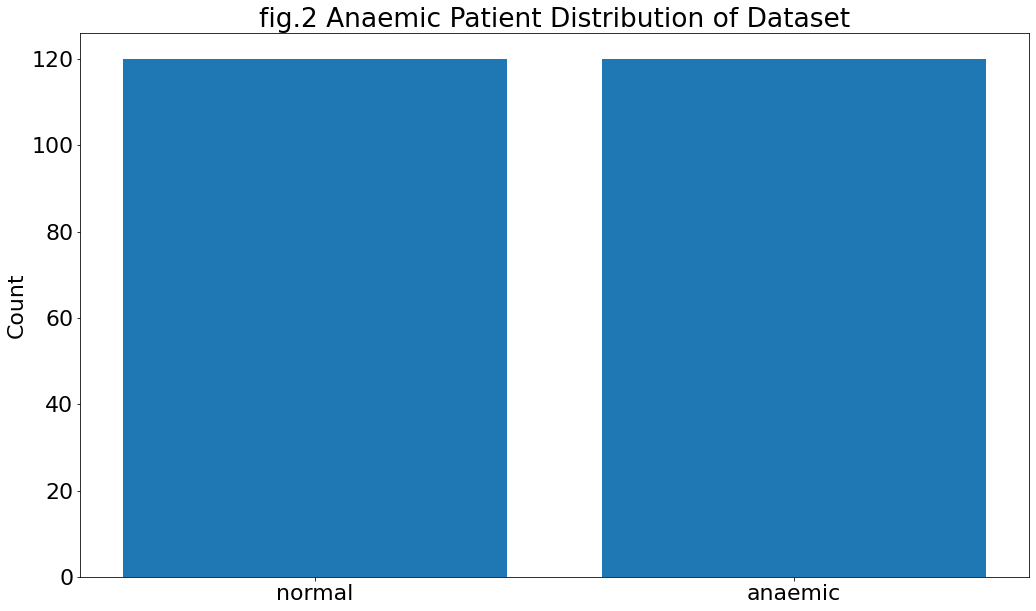

In [27]:
fig02, ax02 = plt.subplots()

ax02.bar(df['anaemia'].unique(), df['anaemia'].value_counts())

plt.title("fig.2 Anaemic Patient Distribution of Dataset")
plt.ylabel("Count")
fig02.set_size_inches(17, 10)
plt.show()

In [28]:
df['anaemia'].value_counts()

normal     120
anaemic    120
Name: anaemia, dtype: int64

Exactly 50% of patients in the dataset suffer from anaemia. This is nearly twice the expected world average, which is said to be anywhere from 25%
{<a href="https://www.ekfdiagnostics.com/who-has-the-highest-risk-of-developing-anemia.html#:~:text=Anemia%2C%20a%20disorder%20characterized%20by,or%201.6%20billion%20people%20worldwide.">ekfdiagnostics.com</a>} 
to 30% {<a href="https://my.clevelandclinic.org/health/diseases/3929-anemia">clevelandclinic.org</a>}.

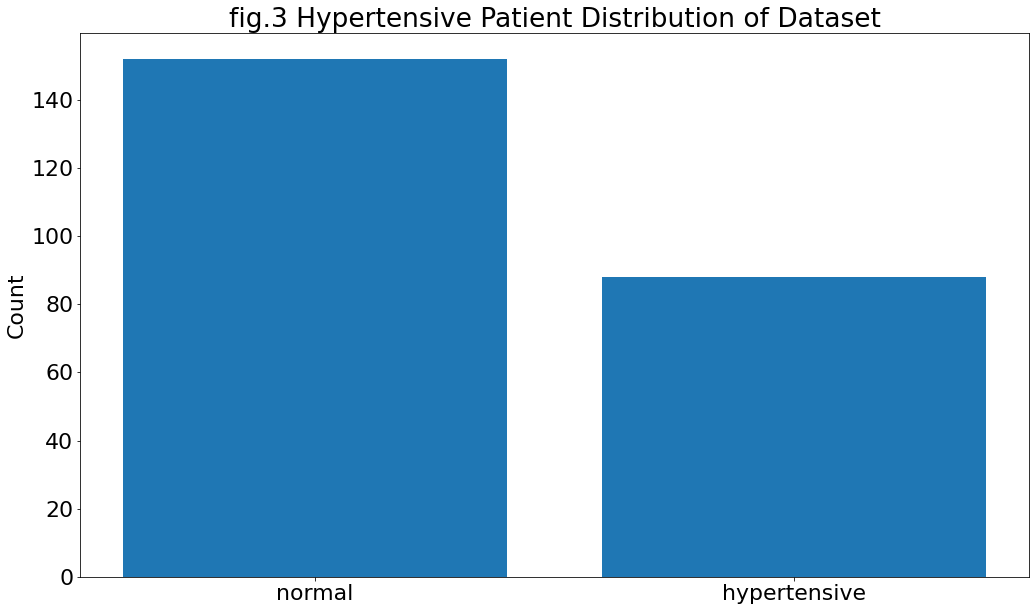

In [29]:
fig03, ax03 = plt.subplots()

ax03.bar(df['high_blood_pressure'].unique(), df['high_blood_pressure'].value_counts())

plt.title("fig.3 Hypertensive Patient Distribution of Dataset")
plt.ylabel("Count")
fig03.set_size_inches(17, 10)
plt.show()

In [30]:
df['high_blood_pressure'].value_counts()

normal          152
hypertensive     88
Name: high_blood_pressure, dtype: int64

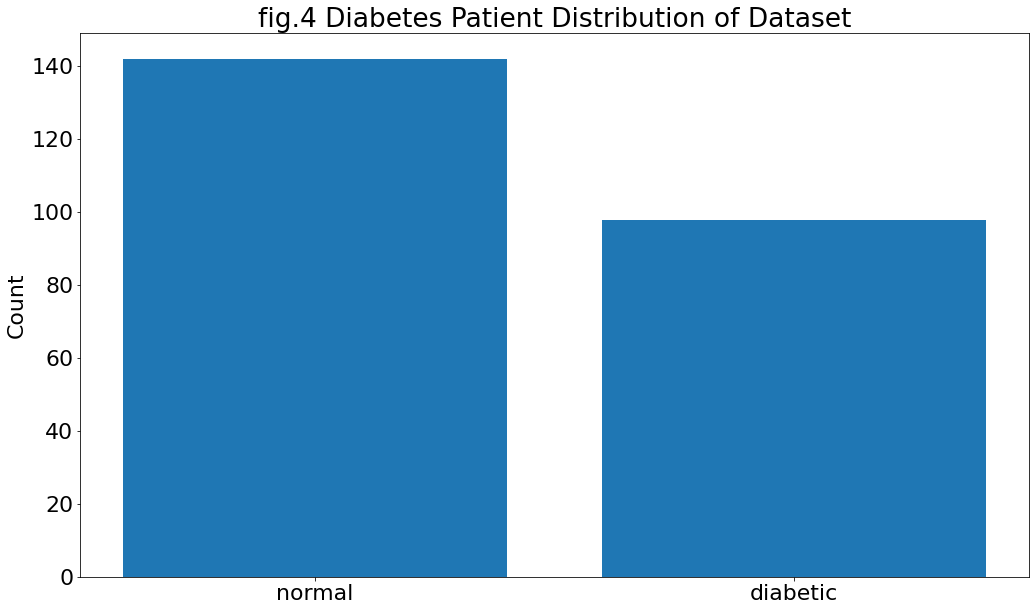

In [31]:
fig04, ax04 = plt.subplots()

ax04.bar(df['diabetes'].unique(), df['diabetes'].value_counts())

plt.title("fig.4 Diabetes Patient Distribution of Dataset")
plt.ylabel("Count")
fig04.set_size_inches(17, 10)
plt.show()

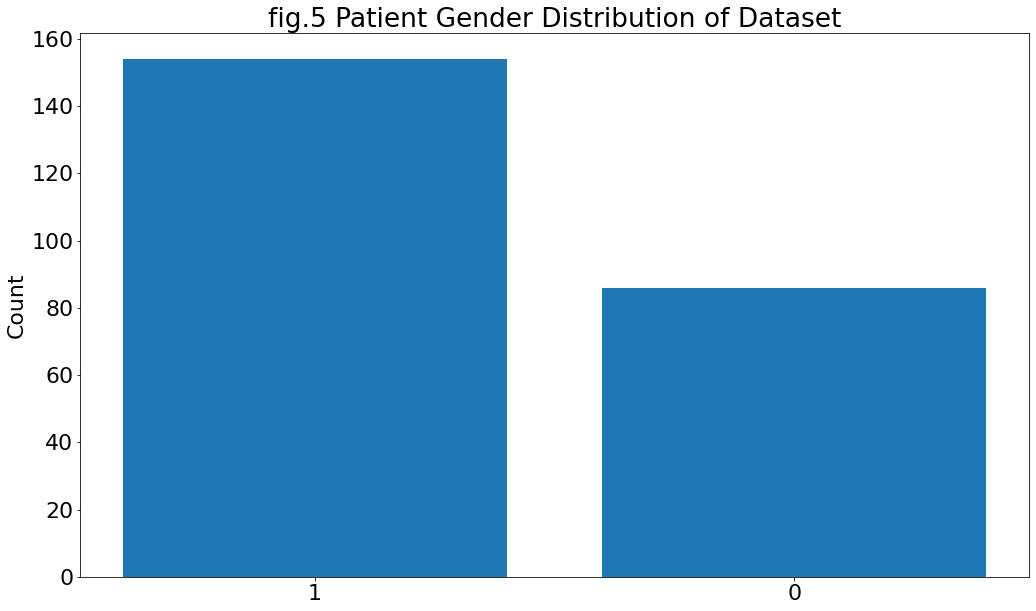

In [32]:
fig05, ax05 = plt.subplots()

ax05.bar([str(i) for i in df['sex'].unique()], df['sex'].value_counts())

plt.title("fig.5 Patient Gender Distribution of Dataset")
plt.ylabel("Count")
fig05.set_size_inches(17, 10)
plt.show()

There is significantly more of one gender in this dataset than the other, yet once again, we cannot know for sure which gender is which as it is not mentioned in the sources.

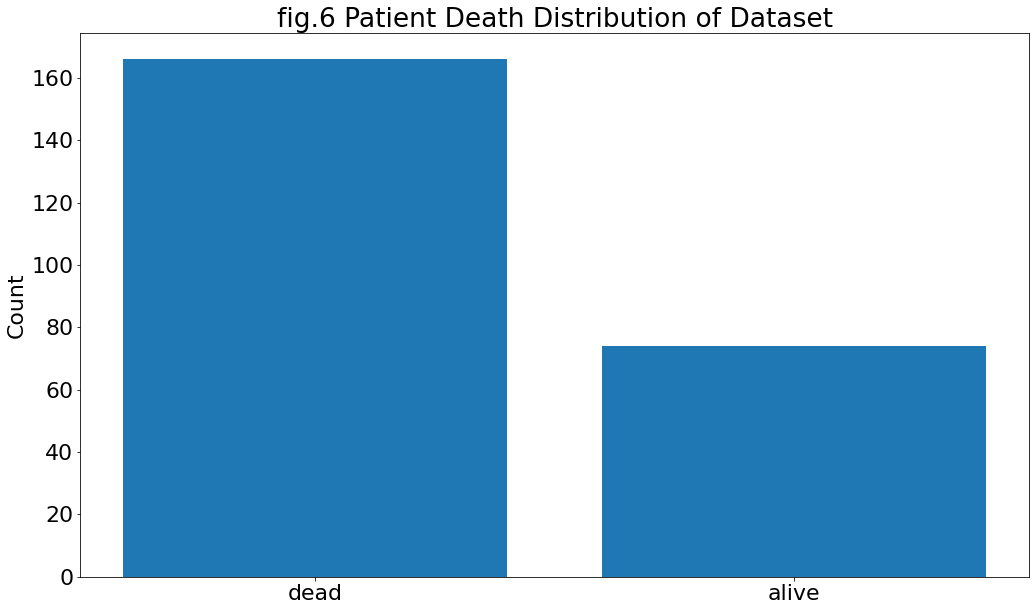

In [33]:
fig06, ax06 = plt.subplots()

ax06.bar(df['DEATH_EVENT'].unique(), df['DEATH_EVENT'].value_counts())

plt.title("fig.6 Patient Death Distribution of Dataset")
plt.ylabel("Count")
fig06.set_size_inches(17, 10)
plt.show()

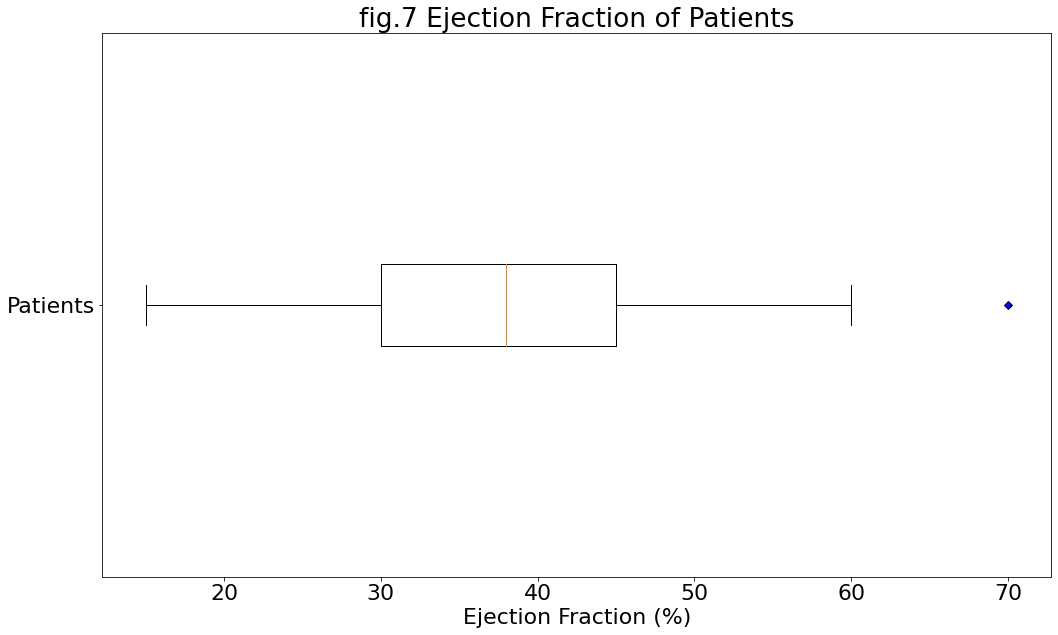

In [34]:
fig07, ax07 = plt.subplots()

ax07.boxplot(df['ejection_fraction'], vert = False, flierprops = dict(markerfacecolor='b', marker='D'), labels = ['Patients'])
plt.title("fig.7 Ejection Fraction of Patients")
plt.xlabel("Ejection Fraction (%)")
fig07.set_size_inches(17, 10)
plt.show()

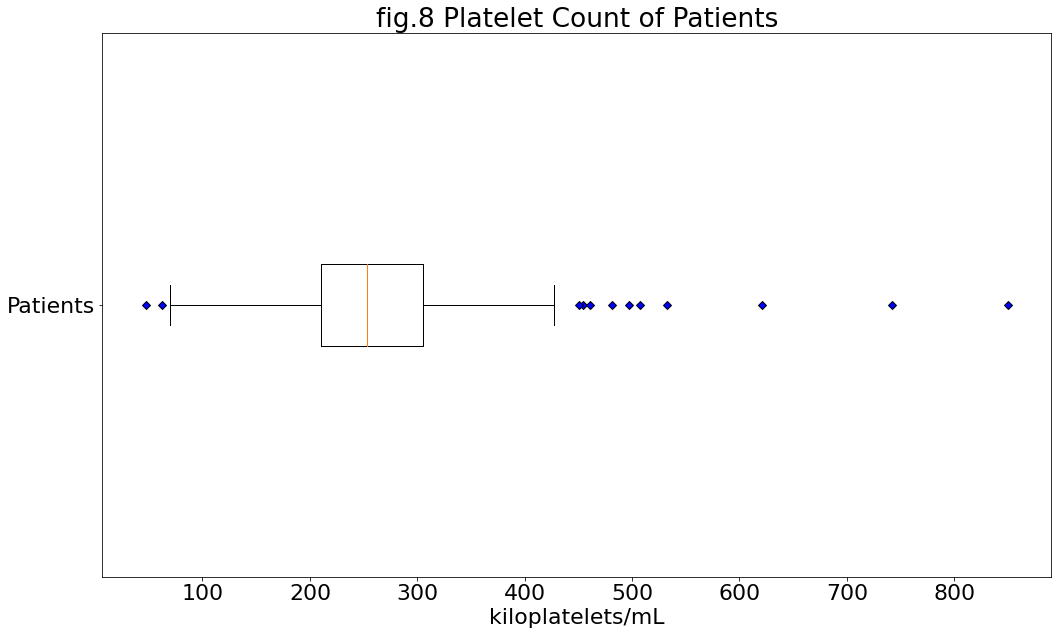

In [35]:
fig08, ax08 = plt.subplots()

ax08.boxplot(df['platelets'], vert = False, flierprops = dict(markerfacecolor='b', marker='D'), labels = ['Patients'])
plt.title("fig.8 Platelet Count of Patients")
plt.xlabel("kiloplatelets/mL")
fig08.set_size_inches(17, 10)
plt.show()

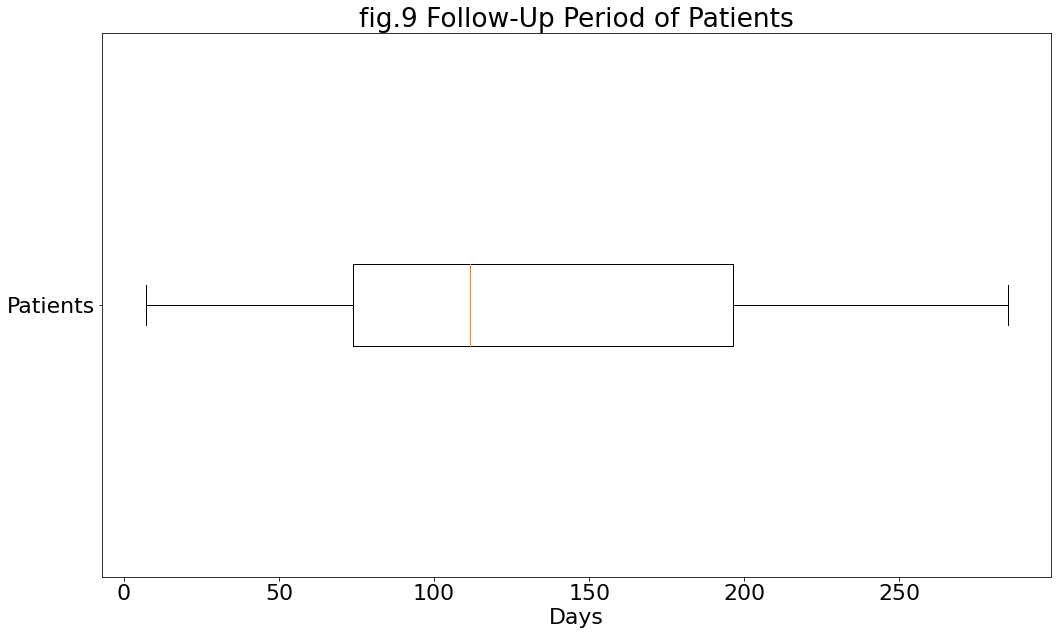

In [36]:
fig09, ax09 = plt.subplots()

ax09.boxplot(df['time'], vert = False, flierprops = dict(markerfacecolor='b', marker='D'), labels = ['Patients'])
plt.title("fig.9 Follow-Up Period of Patients")
plt.xlabel("Days")
fig09.set_size_inches(17, 10)
plt.show()

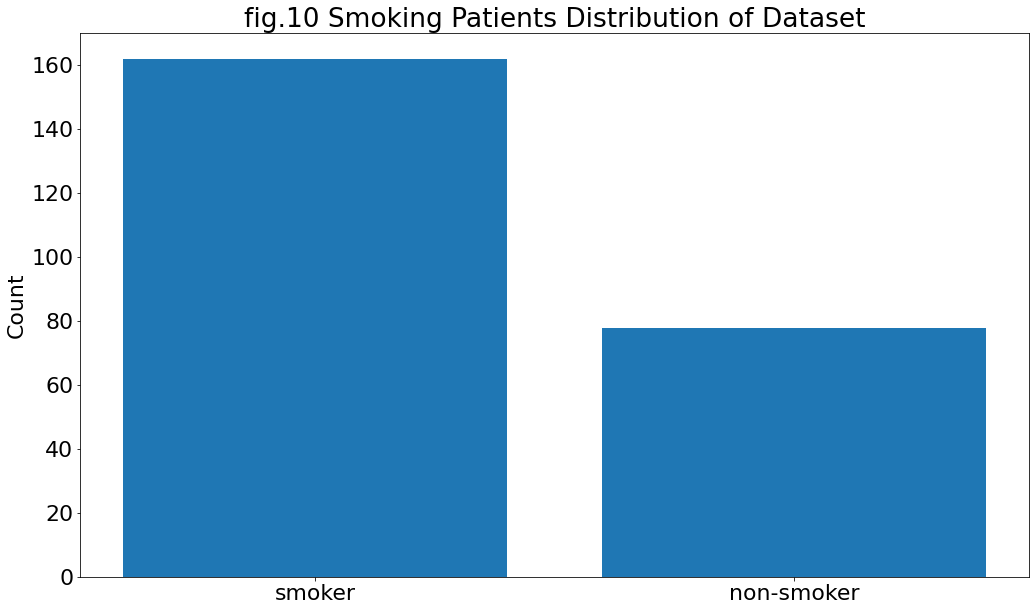

In [37]:
fig10, ax10 = plt.subplots()

ax10.bar(df['smoking'].unique(), df['smoking'].value_counts(sort = False))

plt.title("fig.10 Smoking Patients Distribution of Dataset")
plt.ylabel("Count")
fig10.set_size_inches(17, 10)
plt.show()

In [38]:
df['smoking'].value_counts(sort = False)

non-smoker    162
smoker         78
Name: smoking, dtype: int64

In [39]:
print('Percentage of smokers: ', round(df[df['smoking'] == 'smoker'].shape[0] / df.shape[0], 2) * 100,'%.')

Percentage of smokers:  33.0 %.


Another huge cause for concern: there are significantly more heart failure patients who smoke than those who don't.

=====================================
=

We will proceed with this task beginning by studying the relationship between creatinine phosphokinase (CPK) and serum creatinine.

The normal level of CPK in the blood is `10-120 mcg/L`. {<a href="https://www.mountsinai.org/health-library/tests/creatine-phosphokinase-test">mountsinai.org</a>}

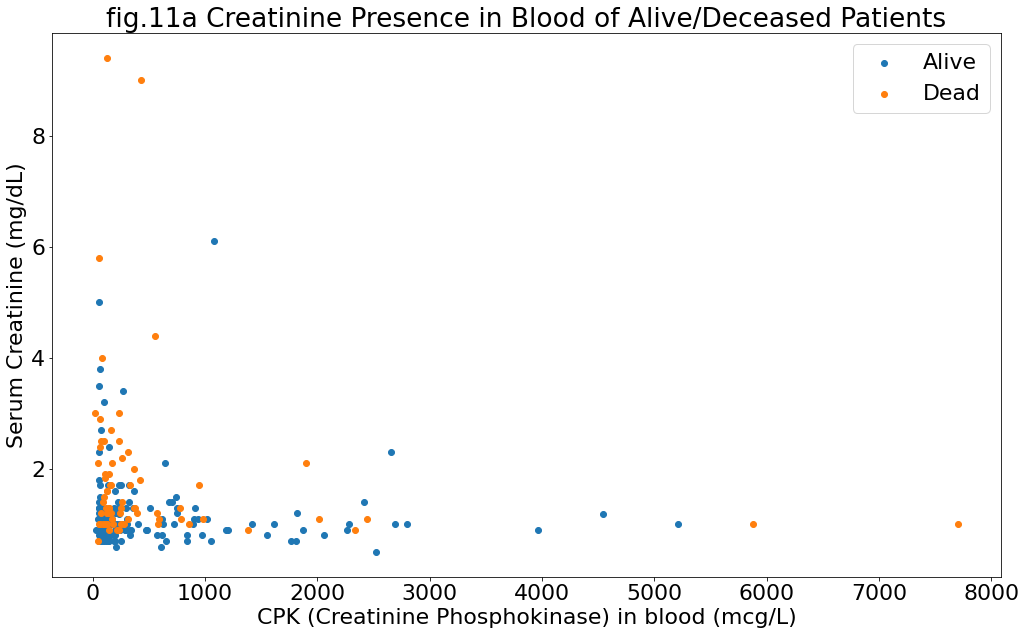

In [40]:
fig11a, ax11a = plt.subplots()

ax11a.scatter(df[df['DEATH_EVENT'] == 'alive']['creatinine_phosphokinase'], 
             df[df['DEATH_EVENT'] == 'alive']['serum_creatinine'],
            label = "Alive")
ax11a.scatter(df[df['DEATH_EVENT'] == 'dead']['creatinine_phosphokinase'], 
             df[df['DEATH_EVENT'] == 'dead']['serum_creatinine'],
            label = "Dead")

plt.title("fig.11a Creatinine Presence in Blood of Alive/Deceased Patients")
plt.xlabel("CPK (Creatinine Phosphokinase) in blood (mcg/L)")
plt.ylabel("Serum Creatinine (mg/dL)")
ax11a.legend()
fig11a.set_size_inches(17, 10)
plt.show()

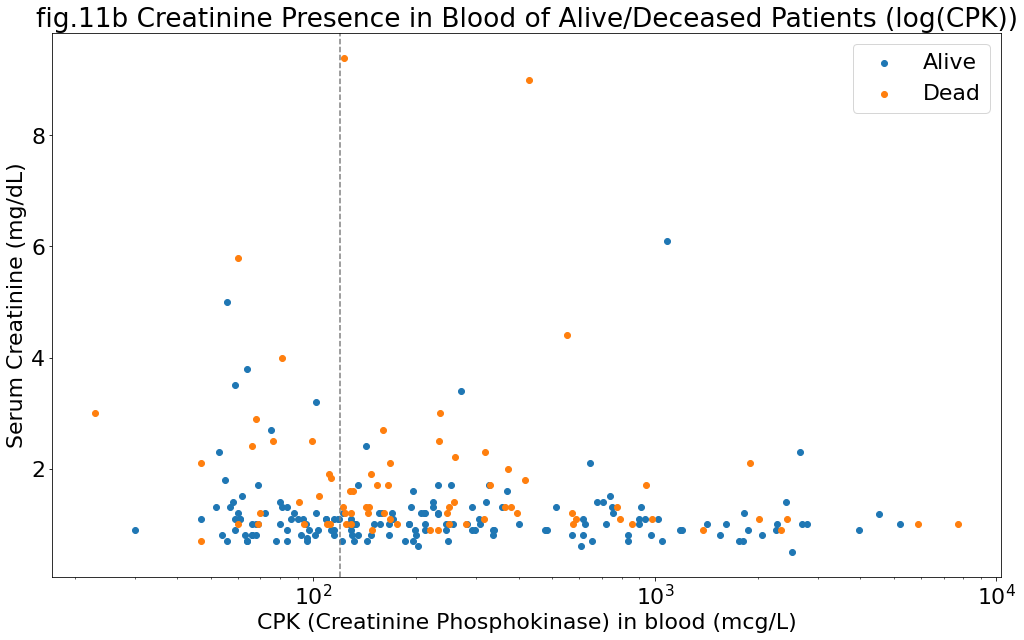

In [41]:
fig11b, ax11b = plt.subplots()

ax11b.scatter(df[df['DEATH_EVENT'] == 'alive']['creatinine_phosphokinase'], 
             df[df['DEATH_EVENT'] == 'alive']['serum_creatinine'],
            label = "Alive")
ax11b.scatter(df[df['DEATH_EVENT'] == 'dead']['creatinine_phosphokinase'], 
             df[df['DEATH_EVENT'] == 'dead']['serum_creatinine'],
            label = "Dead")

# Display max normal CPK level dashed line:
plt.axvline(x=120, color='grey', linestyle='--')

plt.title("fig.11b Creatinine Presence in Blood of Alive/Deceased Patients (log(CPK))")
plt.xlabel("CPK (Creatinine Phosphokinase) in blood (mcg/L)")
plt.ylabel("Serum Creatinine (mg/dL)")
ax11b.legend()
fig11b.set_size_inches(17, 10)

ax11b.set_xscale('log')
plt.show()

At a glance, it can be seen that the levels of CPK and serum creatinine are inversely related. That is, as the amount of CPK in the blood increases, the amount of Serum Creatine decreases, and vice versa.

In [42]:
normal = df[df['creatinine_phosphokinase'] <= 120]
normal[normal['DEATH_EVENT'] == 'alive'].shape[0]

58

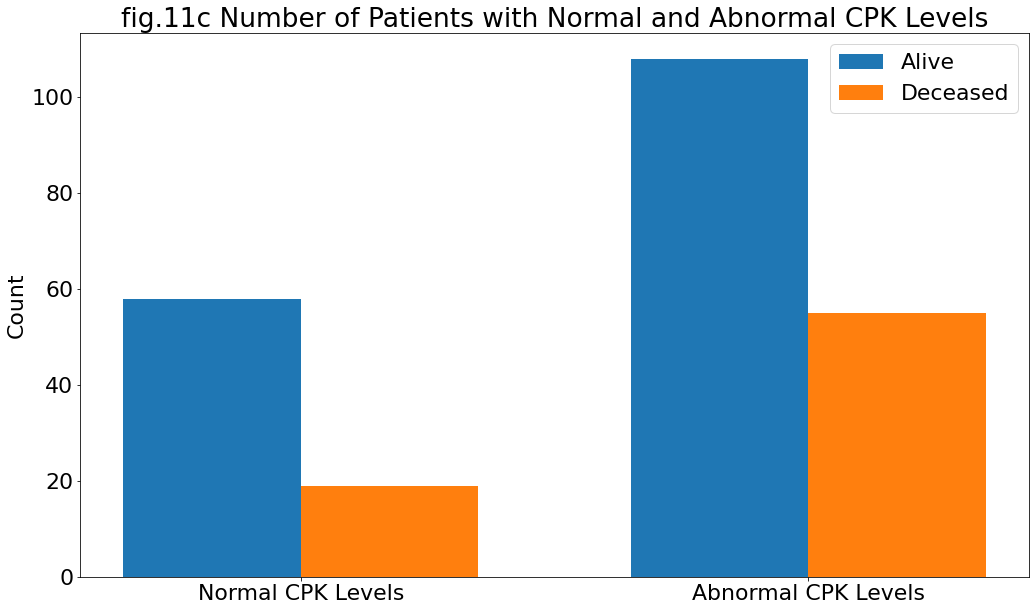

In [43]:
fig11c, ax11c = plt.subplots()

normal = df[df['creatinine_phosphokinase'] <= 120]
abnormal = df[df['creatinine_phosphokinase'] > 120]

labels = ['Normal CPK Levels', 'Abnormal CPK Levels']
alive = [normal[normal['DEATH_EVENT'] == 'alive'].shape[0], abnormal[abnormal['DEATH_EVENT'] == 'alive'].shape[0]]
deceased = [normal[normal['DEATH_EVENT'] == 'dead'].shape[0], abnormal[abnormal['DEATH_EVENT'] == 'dead'].shape[0]]

x = np.arange(len(labels))

width = 0.35

rects1 = ax11c.bar(x - width/2, alive, width, label='Alive')
rects2 = ax11c.bar(x + width/2, deceased, width, label='Deceased')

ax11c.set_ylabel('Count')
ax11c.set_title('fig.11c Number of Patients with Normal and Abnormal CPK Levels')
plt.xticks(x)
ax11c.set_xticklabels(labels)
ax11c.legend()

fig11c.set_size_inches(17, 10)

plt.show()

In [44]:
print("Mortality increases from ", 
      round(normal[normal['DEATH_EVENT'] == 'dead'].shape[0] / normal.shape[0], 2) * 100,
      "% to ",
      round(abnormal[abnormal['DEATH_EVENT'] == 'dead'].shape[0] / abnormal.shape[0], 2) * 100,
      "%.")

Mortality increases from  25.0 % to  34.0 %.


## Data Modelling

The target value(s) for this dataset is the `'DEATH_EVENT'` feature.
We will be using the random state of `'63'`.

In [45]:
# Initiallising modelling and target DataFrames
model_df = df_before_pp.loc[:, df.columns != 'DEATH_EVENT']
target_df = df_before_pp['DEATH_EVENT']

In [46]:
model_df.shape

(240, 12)

In [47]:
target_df.shape

(240,)

In [48]:
# Import ML and analysis modules
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report


# Splitting data 90-10: 90% for training, 10% for testing
# With a small dataset, we require as much training as possible
x_train, x_test, y_train, y_test = train_test_split(model_df, target_df, test_size = 0.1, random_state = 63)
x_train, x_test, y_train, y_test

(     age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
 186   65        0                        56         0                 25   
 155   60        1                       104         1                 30   
 90    45        0                       292         1                 35   
 190   40        1                       129         0                 35   
 235   62        0                        61         1                 38   
 ..   ...      ...                       ...       ...                ...   
 82    65        1                       305         0                 25   
 215   65        1                       258         1                 25   
 139   59        0                        66         1                 20   
 116   46        1                       291         0                 35   
 44    70        1                        75         0                 35   
 
      high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex 

In [49]:
x_train.shape, x_test.shape

((216, 12), (24, 12))

In [50]:
y_train.shape, y_test.shape

((216,), (24,))

In [51]:
# This loop manually finds an acceptable Nearest Neighbor value
for i in range(1,20):
    # Iterate NN & fit
    clf = KNeighborsClassifier(i)
    clf.fit(x_train, y_train)
    
    # pred --> predicted result from test
    pred = clf.predict(x_test)
    pred, y_test
    
    # result --> DataFrame containing the predicted vs actual result
    result = pd.DataFrame(data = {
        'Predicted': pred,
        'Actual': y_test
    })
    # Primary concern: True Negatives (correct death guesses)
    # There are unfortunately no cases where the death of a patient 
    # was predicted successfully more than 3 times.
    if result[(result['Predicted'] == 'dead') & (result['Actual'] == 'dead')].shape[0] > 3:
        print('Nearest Neighbor: ', i, 'Correct Guesses: ', result[result['Predicted'] == result['Actual']].shape[0], ' Correct Death Guesses: ', result[(result['Predicted'] == 'dead') & (result['Actual'] == 'dead')].shape[0])


Nearest Neighbor:  13 Correct Guesses:  21  Correct Death Guesses:  4
Nearest Neighbor:  17 Correct Guesses:  21  Correct Death Guesses:  4


Nearest Neighbor of `13` or `17` is ideal, as it returns an acceptable prediction. We will use `13`.

In [52]:
# Set nearest neighbor value
clf = KNeighborsClassifier(13)
# Fit prediction
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
# Confusion Matirx
cm = confusion_matrix(y_test, pred)
cm

array([[17,  1],
       [ 2,  4]], dtype=int64)

In [53]:
# Classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       alive       0.89      0.94      0.92        18
        dead       0.80      0.67      0.73         6

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24

